# Qualitative Inspection for No Relationship types

This notebook covers the visualization of a sample of qualitatively-inspected concept pair annotations determined by the users to have no relationship

## Import modules and load data

In [11]:
import pandas
import m2c_rel_basic
import relationship_dictionaries
import random
import matplotlib
from matplotlib import pyplot as mplot
from pandas import read_csv

Import the qualitatively inspected sample relationship annotations and complete annotations

In [12]:
savepath = 'data/'
exppath = 'exports/'
QCdata = 'no_relations_QCd.txt'
esample = read_csv(savepath+'QCd samples/'+QCdata, sep='\t', header=0).fillna('none')
esample.drop("Unnamed: 0",axis=1,inplace=True)
all_completed_anns = read_csv(savepath+'all_completed_anns.txt', delimiter='\t', header=0)
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)
print(esample.dtypes)

concept_pair           object
pmid                    int64
reltype                object
counts                  int64
rand value              int64
pair description       object
actual relationship    object
Type                   object
Notes                  object
Note Type              object
meta_path              object
directionality         object
meta_path_length       object
dtype: object


Import the missing relationship types and broad categorical mappings

In [13]:
broad_df = read_csv(savepath+'QCd samples/'+'missing_relation_mappings.txt', sep='\t', header=0)
broad_dict = broad_df.set_index('ID')['Broader class'].to_dict()

### Clean up the imported data for visualization

In [14]:
## Add back details on the concepts from the complete annotations
cpmid_list = all_completed_anns.groupby(['concept_pair','pmid','refid1','refid2','refid1_type','refid2_type']).size().reset_index(name='user_counts')
esample_df = esample.merge(cpmid_list,on=('concept_pair','pmid'),how='left')
esample_df['broad_cats'] = esample['Type']
esample_df.replace({'broad_cats':broad_dict}, inplace=True)

In [6]:
#### Compare the annotations based on number of response types vs counts
responses_vs_counts = esample_df.groupby(['counts','Type','broad_cats']).size().reset_index(name='type_counts')
type_variety = responses_vs_counts.groupby('counts').size().reset_index(name='type_variety')
sample_sizes = esample_df.groupby(['counts']).size().reset_index(name='sample_size')
types_per_cat_count = responses_vs_counts.groupby(['counts','broad_cats']).size().reset_index(name='types_per_cat')
broad_counts = types_per_cat_count.groupby('counts').size().reset_index(name='broad_counts')
general_summary = sample_sizes.merge(type_variety.merge(broad_counts,on='counts',how='left'),on='counts',how='left')
print(general_summary.head(n=2))

   counts  sample_size  type_variety  broad_counts
0       1           25             9             8
1       2           25            12            10


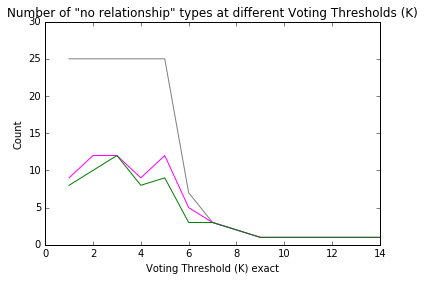

In [15]:
#### Visualize the results
mplot.ylim((0, 30))
mplot.plot(general_summary['counts'], general_summary['sample_size'], color='grey')
mplot.plot(general_summary['counts'], general_summary['type_variety'], color='magenta')
mplot.plot(general_summary['counts'], general_summary['broad_counts'], color='green')
mplot.xlabel('Voting Threshold (K) exact')
mplot.ylabel('Count')
mplot.title('Number of "no relationship" types at different Voting Thresholds (K)')
mplot.show()

#### Create an interactive visual of the qualitatively inspected non-specific relationship annotations for easier interpretation

In [21]:
## bokeh categorical heatmap of results
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import Category20b,Category20,Greys9

esample_viz = esample_df[['counts','Type','broad_cats','refid1','refid2','reltype','actual relationship']].copy()
#broad_cm = m2c_txt_pandas_import(exppath+'broad_cat_color_map')
colormap = {"text explicitly mentions investigating relationship, but not an actual relationship"	:Category20[20][2],
            "text explicitly mentions an association/relationship, but is not more specific":Category20[20][3],
            "concepts are vaguely related by shared biochemical pathway/mechanism/markers, but otherwise unrelated":Category20b[20][0],
            "gene mutation causes disease misdiagnosed as mentioned":Category20b[20][1],
            "chemical failed to treat a disease":Category20b[20][4],
            "mentioned chemical does not affect/interfere with the treatment of the mentioned disease":Category20b[20][3],
            "chemical is altered in the disease":Category20b[20][2],
            "disease conveys resistance to drug":Category20b[20][5],
            "gene resistance associated with disease":Category20b[20][15],
            "gene resistance is the disease/symptom":Category20b[20][12],
            "chem indirectly associated with disease":Category20b[20][8],
            "gene mutation indirectly related to disease class":Category20b[20][9],
            "chem is a pro-drug/precursor for treating disease":Category20b[20][10],
            "chemical treats overarching disease of mention":Category20b[20][11],
            "Case/clinical study shows partial or inconsistent relationship (eg- related in x out of y cases, not in m out of y cases)":Category20b[20][7],
            "has relationship":Category20b[20][13],
            "The concept does not appear in the text":Category20b[20][14],
            "The concept does appear in the text, but is wrong/misidentified/incomplete/out-of-context":Category20b[20][6],
            "gene is a marker used for inspecting samples":Category20b[20][16],
            "chemical is reagent for diagnostic test":Category20b[20][17],
            "chemical is a reagent for testing gene associated with disease":Category20b[20][18],
            "chemical is a byproduct of testing something associated with disease":Category20b[20][19]}

esample_viz['colors']=esample_df['broad_cats']
esample_viz['colors'].replace(colormap, inplace=True)

## Account for uneven sample numbers
k=1
for_heat_map = pandas.DataFrame(columns=('counts','Type','broad_cats','refid1',
                                         'refid2','reltype','colors','dummy','sample_no'))

while k<19:
    try:
        tmpdf = esample_viz.loc[esample_viz['counts']==k].copy()
        avail_entries= len(tmpdf)
        tmpdf.sort_values(['colors'],ascending=True,inplace=True)
        tmpdf['dummy']='no'
        tmpdf.reset_index(drop=True,inplace=True)
        tmpdf['sample_no']=tmpdf.index.copy()
        if avail_entries==25:
            for_heat_map = pandas.concat((for_heat_map,tmpdf))       
        else:
            dummydata = []
            while avail_entries <= 24:
                tmpdict = {'counts':k,'Type':'dummy','broad_cats':'dummy','refid1':'dummy','refid2':'dummy',
                           'dummy':'yes'+str(avail_entries),'colors':Greys9[8],'sample_no':avail_entries}
                dummydata.append(tmpdict)
                avail_entries = avail_entries+1
            dummydf = pandas.DataFrame(dummydata)
            for_heat_map = pandas.concat((for_heat_map,tmpdf,dummydf))
        k=k+1
    except:
        print('no no-relations for that k')

source = ColumnDataSource(for_heat_map)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title = "types of mentions marked as no relationship", tools=["pan,wheel_zoom,box_zoom,reset"])
p.xaxis.axis_label = 'sample #'
p.yaxis.axis_label = 'Total Users Marked'

p.rect(source=source, x='sample_no', y='counts', width=1, height=1,
       fill_color='colors',
       line_color=None)

p.add_tools(HoverTool(tooltips=[    
    ("count", "@counts"),
    ("sample #", "@sample_no"),
    ("broad_cat", "@broad_cats"),
    ("concept 1","@refid1"),
    ("concept 2", "@refid2"),
    ("reltype","@reltype"),
    ("colors","@colors"),
    ("relationship","@{actual relationship}")
    ]))

output_file(exppath+"no_relation_broad_categories.html", title="categories_of_no_relation")

show(p)

INFO:bokeh.core.state:Session output file 'exports/no_relation_broad_categories.html' already exists, will be overwritten.


In [49]:
#### Compare response types vs concepts to see concept variety compared to relationship variety
cp1_no_dups_per_k = esample_df.groupby(['counts','refid1','broad_cats']).size().reset_index(name='cp1_counts')
cp1_variety = cp1_no_dups_per_k.groupby(['counts','refid1']).size().reset_index(name='cats_per_cp1')
cp1_variety2 = cp1_no_dups_per_k.groupby(['counts','broad_cats']).size().reset_index(name='cp1s_per_cat')
cp1_variety2.sort_values(['counts','cp1s_per_cat'], ascending=[True,False],inplace=True)

cp2_no_dups_per_k = esample_df.groupby(['counts','refid2','broad_cats']).size().reset_index(name='cp2_counts')
cp2_variety = cp2_no_dups_per_k.groupby(['counts','refid2']).size().reset_index(name='cats_per_cp2')
cp2_variety2 = cp2_no_dups_per_k.groupby(['counts','broad_cats']).size().reset_index(name='cp2s_per_cat')
cp2_variety2.sort_values(['counts','cp2s_per_cat'], ascending=[True,False],inplace=True)

concept_variety = cp1_variety2.merge(cp2_variety2, on=['counts','broad_cats'],how='outer').fillna(0)
print(concept_variety.head(n=2))

   counts                                         broad_cats  cp1s_per_cat  \
0       1  The concept does appear in the text, but is wr...             4   
1       1                                   has relationship             3   

   cp2s_per_cat  
0             4  
1             6  
